In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix


In [15]:
DATA_PATH = "/kaggle/input/datasets/ipythonx/retinal-vessel-segmentation/DRIVE/training"

IMAGE_PATH = os.path.join(DATA_PATH, "images")
GT_PATH = os.path.join(DATA_PATH, "1st_manual")
FOV_PATH = os.path.join(DATA_PATH, "mask")

image_files = sorted(os.listdir(IMAGE_PATH))
gt_files = sorted(os.listdir(GT_PATH))
fov_files = sorted(os.listdir(FOV_PATH))

print("Total Images:", len(image_files))


Total Images: 20


In [16]:
def preprocess(path):
    img = cv2.imread(path)
    green = img[:, :, 1]   # vessels clearer in green channel
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    
    return enhanced


In [17]:
def extract_thin(mask):
    mask = mask // 255
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=1)
    thin = mask - eroded
    thin[thin < 0] = 0
    return thin


In [18]:
def niblack_threshold(image):
    
    thresh = threshold_niblack(image, window_size=25, k=-0.2)
    binary = (image < thresh).astype(np.uint8)
    
    # remove small noise
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [19]:
def sauvola_threshold(image):
    
    thresh = threshold_sauvola(image, window_size=25, k=0.2)
    binary = (image < thresh).astype(np.uint8)
    
    # remove small noise
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [20]:
def compute_metrics(gt, pred, fov):
    
    valid = (fov // 255).flatten() == 1
    
    gt = gt.flatten()[valid].astype(int)
    pred = pred.flatten()[valid].astype(int)
    
    cm = confusion_matrix(gt, pred, labels=[0,1])
    
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    
    sensitivity = tp / (tp + fn + 1e-8)
    return sensitivity


In [21]:
niblack_results = []
sauvola_results = []

for i in range(len(image_files)):
    
    img = preprocess(os.path.join(IMAGE_PATH, image_files[i]))
    gt = cv2.imread(os.path.join(GT_PATH, gt_files[i]), 0)
    fov = cv2.imread(os.path.join(FOV_PATH, fov_files[i]), 0)
    
    thin_gt = extract_thin(gt)
    
    n_pred = niblack_threshold(img)
    s_pred = sauvola_threshold(img)
    
    niblack_results.append(compute_metrics(thin_gt, n_pred, fov))
    sauvola_results.append(compute_metrics(thin_gt, s_pred, fov))

niblack_results = np.array(niblack_results)
sauvola_results = np.array(sauvola_results)


In [22]:
# Extract sensitivity column
niblack_sens = niblack_results[:]
sauvola_sens = sauvola_results[:]

# Highest sensitivity value
highest_niblack = np.max(niblack_sens)
highest_sauvola = np.max(sauvola_sens)

# Image index where highest occurred
best_img_niblack = np.argmax(niblack_sens)
best_img_sauvola = np.argmax(sauvola_sens)

print("Highest Sensitivity Results")
print("----------------------------")
print("Niblack  Highest Sensitivity :", highest_niblack)
print("Occurred at Image Index      :", best_img_niblack)

print("\nSauvola  Highest Sensitivity :", highest_sauvola)
print("Occurred at Image Index      :", best_img_sauvola)

Highest Sensitivity Results
----------------------------
Niblack  Highest Sensitivity : 0.7941155156164982
Occurred at Image Index      : 10

Sauvola  Highest Sensitivity : 0.3600985578662511
Occurred at Image Index      : 10


In [23]:
print("\n FINAL AVERAGE METRICS ")

print("\nNIBLACK")
print("Sensitivity:", np.mean(niblack_results[19]))

print("\nSAUVOLA")
print("Sensitivity:", np.mean(sauvola_results[19]))


 FINAL AVERAGE METRICS 

NIBLACK
Sensitivity: 0.7410117538599095

SAUVOLA
Sensitivity: 0.34155335330701686


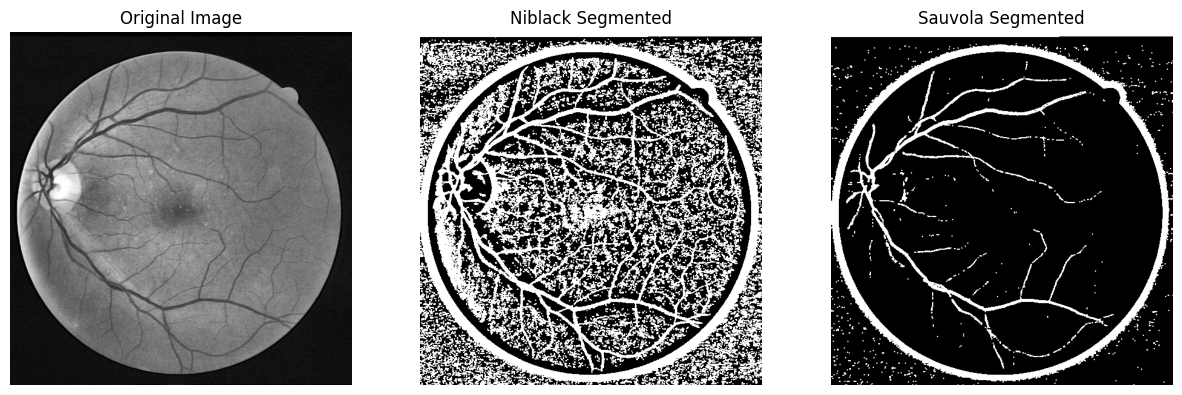

In [24]:
index = 0

img = preprocess(os.path.join(IMAGE_PATH, image_files[index]))

n_pred = niblack_threshold(img)
s_pred = sauvola_threshold(img)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Niblack Segmented")
plt.imshow(n_pred, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Sauvola Segmented")
plt.imshow(s_pred, cmap='gray')
plt.axis("off")

plt.show()
